# Introduction

<p>
For lab 2 students are expected to implement the following regression algorithms (with libraries):
<ul>
    <li>k-nearest neighbors</li>
    <li>Linear Regression</li>
    <li>Ridge Regression</li>
    <li>Regression Trees</li>
    <li>Random Forests</li>
    <li>SVMs</li>
    <li>Mulilayer Perceptrons</li>
</ul>

<p>
These algorithms use the energy.txt dataset which contains five floating point features and one label. These algorithms will produce a prediction of new data. Students are also expected to report their findings on how these algorithms work and which parameters work best.
</p>

<p>
From all these algorithms, we should be able to find which ones best model the dataset and find the models with the best performances. From these models students will be able to predict which algorithms are best different features.
</p>

# Implementation

<p>For the implementation of lab 2 I've elected to use the sklearn libraries. The regression algorithms within this library use the <code>fit</code> and <code>predict</code> methods to train and generalize.</p>

<h5>K-Nearest Neighbors</h5>
<p>This algorithm works by storing a data set (training data) and making predictions by selecting the k samples that have the closest features to the new sample. This algorithm then uses the label(s) from these k samples to predict the new label (usually by taking the mean). There are various alterations besides k. The most significate one is the distance function, which decides how the distance between feature values will be weighted.</p>

<h5>Linear and Ridge Regression</h5>
<p>Linear Regression functions work by computing a linear function that minimizes error between all y values and the function. Algorithms typically uses ordinary least squares to do this which is the sum of the squared distances between the y actuals and the value predicted by the function. Ridge regression fights overfitting and high variance by incorporating L2 regularization.</p>

<h5>Regression Trees</h5>
<p>Regression trees attempts to partition data into like sets by using different function to grade the similarity of data within the subsets. They typically choose features to split with by finding the feature that best splits the data. One side effect of these algorithms is that they tend to produce new labels on a range. This means that trees with few branches tend to overgeneralize data and perform poorly when predicting from extreme features. Additionally, using too many branches (deep trees) can lead to overfitting.</p>

<h5>Random Forests</h5>
<p>Random forests operate off of a statistical convention wherein if a model has a probability of P(A) > .5 that the combined probability is increased if multiple models are combined in an ensemble. These ensembles are also very useful for "weak models". One stipulation of these ensembles, however, is that they need consistently predict better than random and they also have to have some variation between one another. Simply cloning the same model would cause the probability of an erroneous prediction to stay the same. Typically, these ensembles can have the most confident models vote on an answer. Ensembles perform especially well if the models vary on how they choose values from features. Random forests operate by creating random decision trees and using them in an ensemble to make predictions. Random forests are very cleaver because random trees vary a great deal on what features they use for each branch and which thresholds they choose to use.</p>

<h5>Support Vector Machines</h5>
<p>These algorithms attempt to create a channel between two sets of data that is wide as possible. The algorithm works by finding "support vectors" or vectors from points that are relevant to the definition of a decision boundary. Any new feature is then classified based on its computed distance to the support vectors.</p>

<h5>Multilayer Perceptrons</h5>
<p>MLPs are artificial neural networks that use hidden layers with learned weights to make predictions on new features. It learns these weights by making forward passes of training data and using the error to backpropagate changes via gradient descent. The number of layers can be increase to create deep nets that can more accurately classify complex features.</p>    

# Results and Analysis

## Imported Libraries

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Prepare the Data

I have decided to us pandas dataframes to contain the data because of its enhanced API which allows for column and index labeling and fast matrix operations. The data is split into training and testing sets along with a standardized training and testing (just features) for the algorithms that require standardization.

In [63]:
def read_data(path):
    data = pd.read_csv(path, delimiter=",", names=['x1', 'x2', 'x3', 'x4', 'x5', 'y'])
    
    return train_test_split(data[['x1', 'x2', 'x3', 'x4', 'x5']], 
                                             data[['y']], 
                                             test_size=0.20,
                                             train_size=0.80,
                                             random_state=99,
                                             shuffle=True)

X_train, X_test, y_train, y_test = read_data("../res/energy.txt")

standardizer = StandardScaler()
standardizer.fit(X_train)
X_train_std = standardizer.transform(X_train)
X_test_std = standardizer.transform(X_test)

#### Dictionaries used to store the best models for comparison at the end

In [58]:
y_pred = {}
y_pred_best = {}
parameters = {}
models = {}

#### Used in algorithms with a floating point distribution >= 0.0

In [59]:
float_dist = [math.exp(x / 10) for x in range(-100, 100)]

## Models

Default implementations are run to give a baseline of performance that is compared to ones with tuned hyperparameters.

### K-Nearest Neighbors

KNN contains hyperparameters for the number of neighbors and the weights used to compute the distance between features. The number of neighbors should have a big impact on the MSE because it influences how many samples are used to make a prediction. The weight function also should have a significant impact on the error. The default neighbors for this algorithm is 5 which performed relatively well on the "energy" dataset. Uniform weights are used as a default. Uniform causes all weights to be applied equally to the evaluation of a near neighbor.

In [62]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(X_train_std, y_train.as_matrix().ravel())
y_pred["knn"] = knn.predict(X_test_std)

print("Default prediction: ", mean_squared_error(y_pred["knn"], y_test))

Default prediction:  1.1638449650596667


#### Does the number of neighbors matter?

The graph below shows that having just one neighbor performs very poorly and as the number of neighbors increases, the error goes down significantly. The error begins to go up slowly after around 7 to 10. Eventually, if the number of neighbors equals the number of training samples, then the algorithm would be the equivalent of taking an average of the data.

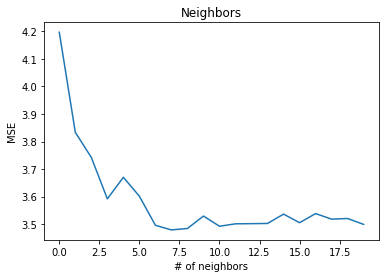

In [60]:
plt.figure()
plt.title("Neighbors")

error = []
for i in range(0, 20):
    knn = KNeighborsRegressor(n_neighbors=i+1)
    knn.fit(X_train, y_train)
    error.append(mean_squared_error(knn.predict(X_test), y_test))
    
plt.plot(error, label='error')
plt.xlabel('# of neighbors')
plt.ylabel('MSE')
plt.show()

#### The best combination of hyperparameters

From the anaysis of all the hyperparameters, the algorithm gives preference to 10 neighbors with distance weights. This makes sense because having 10 neighbors includes enough samples to have a conservative prediction without "bleeding out" predictions with less relivant samples. I would expect the best number of neighbors to go up or down depending on the number of samples and the variance of the data set. Distance weights perform better than uniform because they give weighted significance to feature distances that are very close.

In [7]:
parameters['knn'] = {'n_neighbors':range(1, 50), 'weights':['uniform', 'distance']}

knn = KNeighborsRegressor(algorithm='auto')
knn_best = GridSearchCV(knn, parameters['knn'])
knn_best.fit(X_train_std, y_train)

models['knn'] = knn_best

print("Best Parameters: ", knn_best.best_params_)
print("Default Score ", mean_squared_error(y_pred["knn"], y_test))

y_pred_best["knn"] = knn_best.predict(X_test_std)

print("CV Enhanced Score: ", mean_squared_error(y_pred_best["knn"], y_test))


Best Parameters:  {'n_neighbors': 10, 'weights': 'distance'}
Default Score  1.1433050587066558
CV Enhanced Score:  1.0671411950550704


### Linear Regression

Linear regression lacks any significant parameters because it has a very stock implementation by sklearn. Despite this, it performs comparable to KNN's default. Once KNN's hyperparameters are refined. Linear regression works best when modeling linear relationships between features and predictions.

In [71]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train.as_matrix().ravel())
y_pred["lin_reg"] = lin_reg.predict(X_test)

print("Default prediction: ", mean_squared_error(y_pred["lin_reg"], y_test))

Default prediction:  1.1686934014032144


#### Regressions of each feature

One interesting observation of linear regression's application to this problem is that some of the features (x1 and x2) have distinct linear relationships. The feature x4 appears to have one as well; however, it contains a lot of values clustered at 0.0. I predict that x1 and x2 would be the most significate features for other algorithms as well.

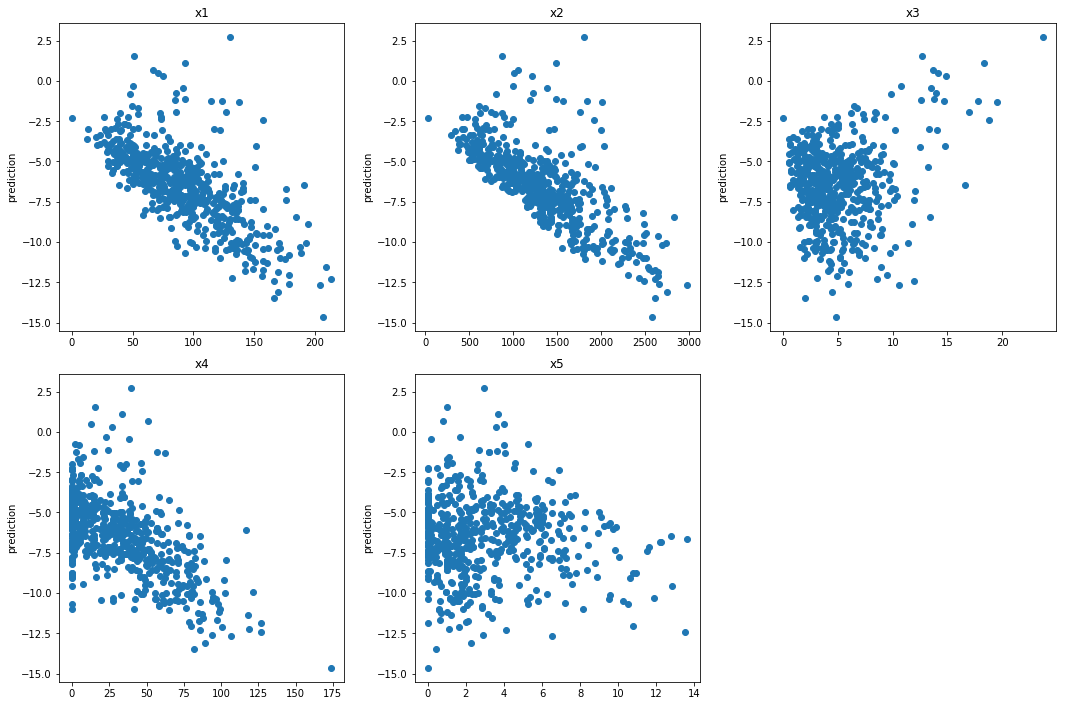

In [72]:
plt.subplots(figsize=(15, 10))

for col_name in X_train:
    _, i = col_name
    i = int(i)
    
    plt.subplot(2, 3, i)
    plt.scatter(X_test[col_name], y_pred['lin_reg'])
    
    plt.ylabel('prediction')
    plt.title(col_name)


plt.tight_layout(pad=1.4, w_pad=1.5, h_pad=1.0)
plt.show()

### Ridge Regression

In [87]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=99)
ridge.fit(X_train, y_train.as_matrix().ravel())
y_pred["ridge"] = ridge.predict(X_test)

print("Default prediction: ", mean_squared_error(y_pred["ridge"], y_test))

Default prediction:  1.1687183317391352


#### How does this compare to linear regression?

The result between ridge and linear are nearly identical. I also tried assigning different alpha values without improving the error. Linear outperforms ridge in every case. I feel that ridge could potentially perform slightly better depending on how the training/testing sets are split (random seed) however the results are likely marginal.

In [88]:
# from sklearn.linear_model import RidgeCV

# ridge_cv = RidgeCV(alphas=float_dist)
# ridge_cv.fit(X_train_std, y_train.as_matrix().ravel())

# y_pred["ridge_reg"] = ridge_cv.predict(X_test_std)

print("Ridge : ", mean_squared_error(y_pred["ridge"], y_test))
print("Linear: ", mean_squared_error(y_pred["lin_reg"], y_test))

Ridge :  1.1687183317391352
Linear:  1.1686934014032144


### Regression Trees

As stated earlier, regression trees split the data by computing the MSE of the subsets (branches) and finding the feature and threshold with the best split. The default implementation performs very poorly (compared to the other algorithms). This model is likely overfitting the data because it doesn't constrain the depth of the tree.

In [93]:
from sklearn.tree import DecisionTreeRegressor


tree = DecisionTreeRegressor(random_state=99)
tree.fit(X_train, y_train.as_matrix().ravel())
y_pred["tree"] = tree.predict(X_test)

print("Default values: ", mean_squared_error(y_pred["tree"], y_test))

Default values:  1.9009169803882657


#### Testing my hypothesis from earlier

Earlier I theorized that X1 and X2 were the most significate features for other algorithms to use. As you can see below, the algorithm chooses to use X1 as its first (most significant) split at d=1 and uses X1/X2 for its d=2 split. You can also see that as the cutoff for X1 decreases from 1100 to 634 the value of the prediction increases from -6.4 to -4.5. This fits the observations in the linear regression graph for X1 above.

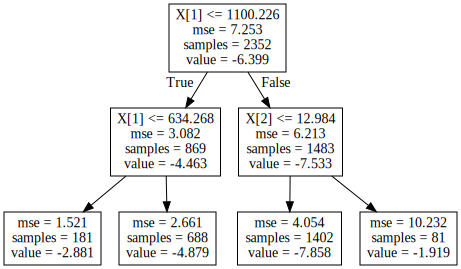

In [96]:
from sklearn.tree import export_graphviz
import graphviz

tree = DecisionTreeRegressor(random_state=99, max_depth=2)
tree.fit(X_train, y_train)

export_graphviz(tree, out_file="/tmp/tree.dot")
with open("/tmp/tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

#### What are the best hyperparameters?

Using cross validation I analyzed the best hyperparameters between 1 to 25. The alorithm selected d=8 as its ideal depth. This makes sense because as the tree gets deeper, the algorithm overfits and vice versa. The algorithm also prefers a impurity decrease of 0.0033 which keeps the algorithm from making near meaningly splits of data. Despite these tunings of the hyperparameters, the decision tree still performs poorly on the dataset when compared to the other algorithms we've seen.

In [97]:
parameters['tree'] = {'max_depth':range(1, 25), 'min_impurity_decrease': float_dist}

tree = DecisionTreeRegressor(random_state=99)
tree_best = GridSearchCV(tree, parameters['tree'])
tree_best.fit(X_train_std, y_train)

models['tree'] = tree_best

print("Best Parameters: ", tree_best.best_params_)
print("Default Score ", mean_squared_error(y_pred["tree"], y_test))

y_pred_best["tree"] = tree_best.predict(X_test_std)

print("CV Enhanced Score: ", mean_squared_error(y_pred_best["tree"], y_test))

Best Parameters:  {'min_impurity_decrease': 0.0005530843701478336, 'max_depth': 8}
Default Score  1.9009169803882657
CV Enhanced Score:  1.8130766846780697


### Random Forests

Given the large possible combination of different features, the random forest ensemble performs very well with a 1.088 MSE for its default of 10 random trees. Thus far this is the best algorithm we've seen for use with this dataset. Since random forest is essentially an ensemble of decision trees, its hyperparameters are a superset of those within decision trees and ensembles. The most important "ensemble parameter" within the forest algorithm should be the <code>n_estimators</code> parameter which determines the number of trees to use to predict.

In [16]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state=99)
forest.fit(X_train, y_train.as_matrix().ravel())
y_pred["forest"] = forest.predict(X_test)

print("Default Score (10 trees): ", mean_squared_error(y_pred["forest"], y_test))

Default Score (10 trees):  1.0880180633546812


#### Does setting the depth matter?

Interestingly, the forest ensemble prefers deeper trees to that of individual decision tree algorithms. Since the random forest polls from multiple algorithms, it is likely more robust towards overfitting than one particular tree. Since the features are split at random. The data also probably isn't partitioned as fast into significant groups.

In [17]:
parameters['forest'] = {'max_depth': [None] + list(range(1, 30))}

forest = RandomForestRegressor(random_state=99)
forest_best = GridSearchCV(forest, parameters['forest'])
forest_best.fit(X_train_std, y_train.as_matrix().ravel())

models['forest'] = forest_best

print("Best Parameters: ", forest_best.best_params_)
print("Default Score ", mean_squared_error(y_pred["forest"], y_test))

y_pred_best["forest"] = forest_best.predict(X_test_std)

print("CV Enhanced Score: ", mean_squared_error(y_pred_best["forest"], y_test))

Best Parameters:  {'max_depth': 12}
Default Score  1.0880180633546812
CV Enhanced Score:  1.0706217756957312


#### How many trees should a forest have?

The random forest performs better with more and more trees. Unfortunately, this adds computational complexity to the algorithm; however, the base principle of ensembles mean that any added model that has good certainty about a prediction can contribute to the prediction.

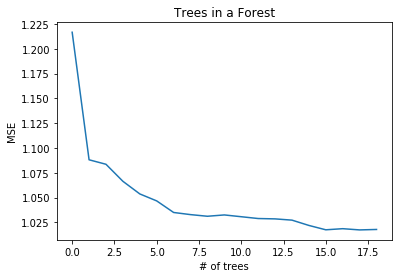

In [26]:
plt.figure()
plt.title("Trees in a Forest")

error = []
for i in range(1, 20):
    forest = RandomForestRegressor(random_state=99, n_estimators=i*5)
    forest.fit(X_train, y_train.as_matrix().ravel())
    error.append(mean_squared_error(forest.predict(X_test), y_test))
    
plt.plot(error, label='error')
plt.xlabel('# of trees')
plt.ylabel('MSE')
plt.show()

### SVM Regression

SVM performs suprisingly well on the dataset with a 0.95 MSE. Standardizing the data is extremely important for this model (non-standardized data scored 7.6). The SVM appears multiple features better than random forests (or any other algorithms we've seen). 

In [100]:
from sklearn.svm import SVR

svm = SVR()
svm.fit(X_train_std, y_train.as_matrix().ravel())
y_pred["svm"] = svm.predict(X_test_std)

print("MSE: ", mean_squared_error(y_pred["svm"], y_test))

MSE:  0.9629951631376539


In [25]:
parameters['svm'] = {'degree':[1, 2, 3, 4, 5], 
                     'shrinking': [True, False], 
                     "kernel": ['linear', 'poly', 'rbf', 'sigmoid']}

svm = SVR()
svm_best = GridSearchCV(svm, parameters['svm'])
svm_best.fit(X_train_std, y_train.as_matrix().ravel())

models['svm'] = svm_best

print("Best Parameters: ", svm_best.best_params_)
print("Default Score ", mean_squared_error(y_pred["svm"], y_test))

y_pred_best["svm"] = svm_best.predict(X_test_std)

print("CV Enhanced Score: ", mean_squared_error(y_pred_best["svm"], y_test))

Best Parameters:  {'kernel': 'rbf', 'shrinking': False, 'degree': 1}
Default Score  0.9522681166953314
CV Enhanced Score:  0.9522418874676214


### Multilayer Perceptron

The algorithms with the best predictions I observed was the MLP. This algorithm produced a 0.90 MSE for the data with defaults! MLP works best for learning important features from high dimensional inputs so it naturally performs very well for the energy dataset. One potential drawback is that the algorithm needs a lot of iteration to train and backpropagate. Overtime the algorithm can also overfit the data. This was mitigated by using early stopage (storing the best seen weights and returning them when the error starts to go up).

In [101]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(random_state=99, max_iter=400, early_stopping=True)
mlp.fit(X_train_std, y_train.as_matrix().ravel())
y_pred["mlp"] = mlp.predict(X_test_std)

print("Default MSE: ", mean_squared_error(y_pred["mlp"], y_test))

Default MSE:  0.9078304717677032


#### How big should the layers be?

Changing the size of one hidden layer caused the error to go down but the results were fairly erratic, so making a reasonable prediction of an ideal layer size was rather challenging.

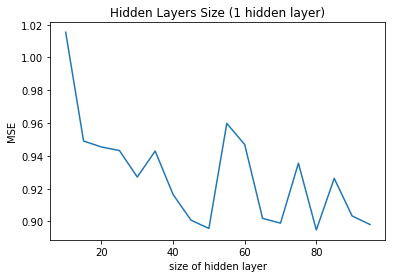

In [39]:
plt.figure()
plt.title("Hidden Layers Size (1 hidden layer)")

error = []
for i in range(10, 100, 5):
    mlp = MLPRegressor(random_state=99, hidden_layer_sizes=i, early_stopping=True, max_iter=400)
    mlp.fit(X_train_std, y_train.as_matrix().ravel())
    error.append(mean_squared_error(mlp.predict(X_test_std), y_test))
    
plt.plot(range(10, 100, 5), error, label='error')
plt.xlabel('size of hidden layer')
plt.ylabel('MSE')
plt.show()

#### How many hidden layers to use?

Given the burdensome complexity of training a NN, using cross validation for many parameters would be rather burdensome. We can see, however, that as the number of hidden layers increase the algorithm "generally" performs better. 

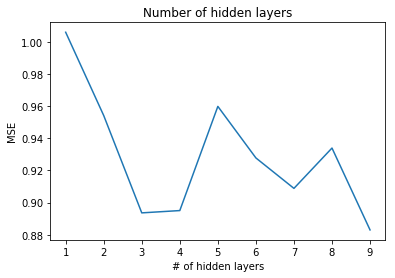

In [40]:
plt.figure()
plt.title("Number of hidden layers")

error = []
hidden_layers = (11)
for i in range(1, 10):
    mlp = MLPRegressor(random_state=99, hidden_layer_sizes=hidden_layers, early_stopping=True, max_iter=400)
    mlp.fit(X_train_std, y_train.as_matrix().ravel())
    error.append(mean_squared_error(mlp.predict(X_test_std), y_test))
    hidden_layers += (11)
    
plt.plot(range(1, 10), error, label='error')
plt.xlabel('# of hidden layers')
plt.ylabel('MSE')
plt.show()

From the observations on the layer sizes and depths, I've decided to train a 100 x 9 MLP. The MSE from this was 0.88 which has a lower error rate than the default at 0.90 and all the other algorithms.

In [106]:
mlp_best = MLPRegressor(random_state=99, max_iter=400, early_stopping=True, hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100))
mlp_best.fit(X_train_std, y_train.as_matrix().ravel())
y_pred["mlp"] = mlp.predict(X_test_std)

models["mlp"] = mlp_best

y_pred_best["mlp"] = mlp_best.predict(X_test_std)

mean_squared_error(y_pred_best["mlp"], y_test)

0.8811536014381465

# Conclusion


From what I have observed in lab 2 I can conclude that algorithms that handle more complex features work better on the energy dataset. Algorithms like SVM and MLP performed the best on the data, whereas algorithms like linear regression made predictions that were too general. This lab also did an exellent job representing the limitions of decision trees (by themselves) as well as the power of statistical ensemble methods. Given the success of the MLP algorithm, I would recomment future experimentation with activation function and variation of layer sizes to improve accuracy. I would also be interested in making comparisons of these algorithms on dissimilar datasets.